In [1]:
%run __init__.py

In [568]:
import pandas as pd
import numpy as np
from joblib import dump, load
from langdetect import detect
from wordcloud import WordCloud
from sklearn.preprocessing import OneHotEncoder
from nlp import NLP_stat, polarity_score, text_tonkenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
import plot
from word2vec import make_model, class_weights_ohe

[nltk_data] Downloading package stopwords to /Users/boula/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/boula/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [874]:
apple_news_df = pd.read_csv('./data/apple_news_scraped.csv.gz')

## DATA SCRUBBING

In [875]:
apple_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    10450 non-null  int64 
 1   Unnamed: 0.1  10450 non-null  int64 
 2   news_url      10450 non-null  object
 3   image_url     10450 non-null  object
 4   title         10450 non-null  object
 5   text          10450 non-null  object
 6   source_name   10450 non-null  object
 7   date          10450 non-null  object
 8   topics        10450 non-null  object
 9   sentiment     10450 non-null  object
 10  type          10450 non-null  object
 11  tickers       8455 non-null   object
 12  articles      9524 non-null   object
dtypes: int64(2), object(11)
memory usage: 1.0+ MB


In [876]:
apple_news_df.head(3)

,Unnamed: 0,Unnamed: 0.1,news_url,image_url,title,text,source_name,date,topics,sentiment,type,tickers,articles
0,0,0,https://www.cnbc.com/2021/05/25/home-prices-in...,https://cdn.snapi.dev/images/v1/b/m/104669168-...,Home prices in March saw highest growth in ove...,"Home prices in March were up 13%, one of the l...",CNBC,"Tue, 25 May 2021 09:01:19 -0400",[],Neutral,Article,NaN,Home prices in March were 13.2% higher in Mar...
1,1,1,https://www.reuters.com/article/us-usa-economy...,https://cdn.snapi.dev/images/v1/a/s/m02d202105...,U.S. home prices rose more than expected in Ma...,U.S. single-family home prices in 20 key urban...,Reuters,"Tue, 25 May 2021 09:09:00 -0400",[],Neutral,Article,NaN,U.S. single-family home prices in 20 key urban...
2,2,2,https://www.reuters.com/article/us-usa-economy...,https://cdn.snapi.dev/images/v1/8/c/m02d202105...,U.S. new home sales drop in April; March sales...,Sales of new U.S. single-family homes dropped ...,Reuters,"Tue, 25 May 2021 10:33:00 -0400",[],Negative,Article,NaN,A carpenter works on building new townhomes th...


#### Missing Values

we start by droping unnecessary columns

In [877]:
cols_to_drop = ['Unnamed: 0', 'Unnamed: 0.1', 'news_url', 'image_url', 'text', 'topics', 'type', 'tickers']
apple_news_df.drop(labels=cols_to_drop, axis=1, inplace=True)

In [878]:
miss_articles = apple_news_df['articles'].isna()
print(f"Total Missing Articles: {miss_articles.sum()}")

Total Missing Articles: 926


As result of scraping 10,450 websites we got 91.13% of successful scrape articles, but we also end up missing  926 websites. this probably due to websites restriction like cookies and CAPTCHA Blocking,  IP Blocking & Proxy Servers, etc..
those 926 row are going to be droped from our dataframe

In [879]:
apple_news_df.drop(apple_news_df.loc[miss_articles].index, inplace=True)

In [880]:
apple_news_df.reset_index(drop=True, inplace=True)

#### DateTime

In [881]:
apple_news_df.loc[:5,'date']

0    Tue, 25 May 2021 09:01:19 -0400
1    Tue, 25 May 2021 09:09:00 -0400
2    Tue, 25 May 2021 10:33:00 -0400
3    Tue, 25 May 2021 07:10:00 -0400
4    Tue, 25 May 2021 12:30:41 -0400
5    Tue, 25 May 2021 02:07:04 -0400
Name: date, dtype: object

In [882]:
apple_news_df['date'].str.findall("\s-[0-9]{4}$").apply(lambda x: ''.join(x)).unique()

array([' -0400', ' -0500'], dtype=object)

In [883]:
# we found dates end with noise strings like '-0400' and '-0500', those are going to be removed using
# builin pandas RegEx.
apple_news_df['date'] = apple_news_df['date'].str.replace("\s-[0-9]{4}$", '', regex=True)

In [884]:
# convert date from string date format to DateTime object using standard ISO-8601 formated YYYY-MM-DDTHH:MM:SS.
apple_news_df['date'] = pd.to_datetime(apple_news_df['date'], format="%a, %d %b %Y %H:%M:%S")

In [885]:
apple_news_df.loc[:5,'date']

0   2021-05-25 09:01:19
1   2021-05-25 09:09:00
2   2021-05-25 10:33:00
3   2021-05-25 07:10:00
4   2021-05-25 12:30:41
5   2021-05-25 02:07:04
Name: date, dtype: datetime64[ns]

In [886]:
apple_news_df.rename(columns={'sentiment':'status', 'source_name':'source'}, inplace=True)

Using langdetect in order to indentify articles language, ensure articles are only english

In [377]:
language = apple_news_df['articles'].apply(detect)

In [378]:
language.value_counts()

en    9524
Name: articles, dtype: int64

## PREPROCESSING

In this section we start by preparing our data for modeling, first by cleaning and tokenizing the articles text applying the function 'text_tokenize' and lastely evaluate the sentiment analysis applying 'polarity_score function.

Text Tonkenization

Remove punctuation, special characters, numbers

In [888]:
stop_words=stopwords.words('english')

In [889]:
apple_news_df['articles'] = apple_news_df['articles'].apply(lambda txt: txt.lower())

In [890]:
apple_news_df['articles'] = apple_news_df['articles']\
                            .apply(lambda txt: ' '.join([word for word in txt.split() if word not in stop_words]))

In [891]:
word_tokenizer = RegexpTokenizer('[a-zA-Z]+')

In [892]:
apple_news_df['articles'] = apple_news_df['articles']\
                            .apply(lambda txt: word_tokenizer.tokenize(txt))

In [893]:
apple_news_df['articles'] = apple_news_df['articles'].apply(lambda x: ' '.join(x))

In [895]:
lemmatizer = WordNetLemmatizer()
apple_news_df['articles'] = apple_news_df['articles'].apply(lambda txt: lemmatizer.lemmatize(txt))

In [896]:
single_chars = re.compile(r"(^\w{1})(?=\s)|(?<=\s)[\w]{1}(?=\s)")
apple_news_df['articles'] = apple_news_df['articles'].apply(lambda txt: single_chars.sub('', txt))

VADER - Sentiment Analysis

in this section we're going to apply 'VADER' pre-trained model on articles text in order to evaluate the sentiment analysis scores with 0.05 as standard threshold.

In [897]:
apple_news_df['articles'] =  text_tonkenize(apple_news_df['articles'])

In [898]:
scores = polarity_score(apple_news_df['articles'])

In [899]:
scores.head()

,text,negative,neutral,positive,compound,sentiment
0,home prices march higher march compared march ...,0.077,0.799,0.124,0.9393,positive
1,single family home prices key urban markets ...,0.064,0.812,0.124,0.9186,positive
2,carpenter works building new townhomes still c...,0.071,0.841,0.088,0.8176,positive
3,wall street bank chiefs tout role institutions...,0.102,0.765,0.132,0.9019,positive
4,paul la monica cnn business updated pm et tue...,0.073,0.927,0.000,-0.2960,negative


In [900]:
apple_news_df = pd.concat([apple_news_df, scores['sentiment']], axis=1, ignore_index=False, sort=False).reindex()

In [901]:
apple_news_df.head()

,title,source,date,status,articles,sentiment
0,Home prices in March saw highest growth in ove...,CNBC,2021-05-25 09:01:19,Neutral,home prices march higher march compared march ...,positive
1,U.S. home prices rose more than expected in Ma...,Reuters,2021-05-25 09:09:00,Neutral,single family home prices key urban markets ...,positive
2,U.S. new home sales drop in April; March sales...,Reuters,2021-05-25 10:33:00,Negative,carpenter works building new townhomes still c...,positive
3,Wall Street bank CEOs to tout COVID relief pus...,Reuters,2021-05-25 07:10:00,Positive,wall street bank chiefs tout role institutions...,positive
4,"In 2008, he was CEO of the biggest bank to eve...",CNN Business,2021-05-25 12:30:41,Negative,paul la monica cnn business updated pm et tue...,negative


In [902]:
apple_news_df['sentiment'].value_counts()

positive    8375
negative    1076
neutral       73
Name: sentiment, dtype: int64

In [903]:
apple_news_df.drop(apple_news_df.loc[(apple_news_df['sentiment'] == 'neutral')].index, inplace=True)

In [904]:
apple_news_df.to_csv('./data/apple_news_cleaned.csv.gz', index=False, compress='gzip')

In [3]:
apple_news_df = pd.read_csv('./data/apple_news_cleaned.csv.gz')

In [4]:
stat = NLP_stat(apple_news_df['articles'])

In [5]:
apple_news_df['word_count'] = stat.WordsCount

## MODELING

In [7]:
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [8]:
sentences = apple_news_df['articles'].apply(lambda x: x.split()).to_list()
max_lenght = 100

In [9]:
l_encoder = LabelEncoder()
y_encoded = l_encoder.fit_transform(apple_news_df['sentiment'])

In [475]:
ohe = OneHotEncoder(sparse=False)
y_ohe = ohe.fit_transform(apple_news_df['sentiment'].values.reshape(-1,1))

In [10]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(apple_news_df['articles'])
sequences = tokenizer.texts_to_sequences(apple_news_df['articles'])
word_index = tokenizer.word_index
# total vocabulary size plus 0 for unknown words
vocab_size = len(tokenizer.word_index) + 1
data = pad_sequences(sequences, max_lenght)
labels = to_categorical(y_encoded)

In [11]:
print(f"{'Unique Words':25} {len(tokenizer.index_word)}")
print(f"{'Shape of data tensor':25} {data.shape}")
print(f"{'Shape of label tensor':25} {labels.shape}")

Unique Words              36827
Shape of data tensor      (9451, 100)
Shape of label tensor     (9451, 2)


In [12]:
word2vec = Word2Vec(sentences,
                     size=max_lenght,
                     window=5,
                     min_count=1,
                     workers=4,
                    )
word2vec.train(sentences, total_examples=word2vec.corpus_count, epochs=5)

pretrained_weights = word2vec.wv.vectors
vocab_size, emdedding_size = pretrained_weights.shape

vectors = np.asarray(word2vec.wv.vectors)

In [11]:
word2vec.save('./word2vec/word2vrc_model')

In [13]:
len(word_index), len(word2vec.wv.vocab)

(36827, 36827)

In [14]:
embedding_matrix = np.zeros((vocab_size+1, emdedding_size))
for word, idx in word_index.items():
        embedding_matrix[idx] = word2vec.wv[word]

dump(embedding_matrix, './word2vec/embedding_matrix.pkl', compress=5)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.15, random_state=1, stratify=labels)
X_train, X_val, y_train, y_val   = train_test_split(data, labels, test_size=.15, random_state=1, stratify=labels)

print(f"Train\n\t{'X :':5}{X_train.shape}\n\t{'Y :':5}{y_train.shape}")
print(f"Test\n\t{'X :':5}{X_test.shape}\n\t{'Y :':5}{y_test.shape}")
print(f"Validation\n\t{'X :':5}{X_val.shape}\n\t{'Y :':5}{y_val.shape}")

Train
	X :  (8033, 100)
	Y :  (8033, 2)
Test
	X :  (1418, 100)
	Y :  (1418, 2)
Validation
	X :  (1418, 100)
	Y :  (1418, 2)


In [16]:
input_dim = embedding_matrix.shape[0]
embedding_dim = embedding_matrix.shape[1]
max_seq_len = data.shape[1]

In [ ]:
BIAS = class_weights_ohe(labels)
METRICS = ['accuracy']
EPOCHS = 32
BATCH_SIZE = 400
STEPS_x_EPOCH = X_train.shape[0]//BATCH_SIZE

In [230]:
eStop_Val_Loss = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=12,
                            verbose=1,mode='min',baseline=0.999,restore_best_weights=False)
eStop_Loss     = EarlyStopping(monitor='loss', min_delta=0.001, patience=12,
                            verbose=1,mode='min',baseline=0.999,restore_best_weights=False)
eStop_Accuracy = EarlyStopping(monitor='accuracy', min_delta=0.001, patience=24,
                            verbose=1, mode='max', baseline=0.999, restore_best_weights=False)
eStop_Val_accuracy  = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=24,
                            verbose=1, mode='max', baseline=0.999, restore_best_weights=False)

eStop_Reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=0.000001, verbose=1)

In [201]:
keras.backend.clear_session()

In [202]:
model = make_model(metrics=METRICS,
                   input_dim=input_dim,
                   embedding_dim=embedding_dim,
                   weights=embedding_matrix,
                   input_length=max_seq_len,
                   output_bias=BIAS
                  )

In [203]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          3682800   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 200)          160800    
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                13888     
_________________________________________________________________
dense16 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
output4 (Dense)              (None, 2)                 34        
Total params: 3,857,794
Trainable params: 174,994
Non-trainable params: 3,682,800
________________________________________

In [204]:
model.layers[0].embeddings_initializer = keras.initializers.GlorotUniform()
model.layers[3].activation = tf.keras.activations.swish

In [198]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    validation_split=0.1,
                    validation_batch_size=1,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=STEPS_x_EPOCH,
                    use_multiprocessing = True,
                    callbacks=[eStop_Val_accuracy, eStop_Val_Loss],
                    workers=6
                    )

Epoch 1/32
20/20 [==============================] - 23s 906ms/step - loss: 2.7740 - accuracy: 0.1187 - val_loss: 0.9841 - val_accuracy: 0.1206
Epoch 2/32
20/20 [==============================] - 17s 848ms/step - loss: 0.9613 - accuracy: 0.4958 - val_loss: 0.3819 - val_accuracy: 0.8794
Epoch 3/32
20/20 [==============================] - 17s 859ms/step - loss: 0.6506 - accuracy: 0.7170 - val_loss: 0.3675 - val_accuracy: 0.8794
Epoch 4/32
20/20 [==============================] - 17s 859ms/step - loss: 0.6192 - accuracy: 0.7569 - val_loss: 0.3707 - val_accuracy: 0.8794
Epoch 5/32
20/20 [==============================] - 17s 867ms/step - loss: 0.6102 - accuracy: 0.7637 - val_loss: 0.3662 - val_accuracy: 0.8794
Epoch 6/32
20/20 [==============================] - 17s 877ms/step - loss: 0.5447 - accuracy: 0.7821 - val_loss: 0.3596 - val_accuracy: 0.8794
Epoch 7/32
20/20 [==============================] - 17s 882ms/step - loss: 0.5343 - accuracy: 0.7923 - val_loss: 0.3470 - val_accuracy: 0.8794

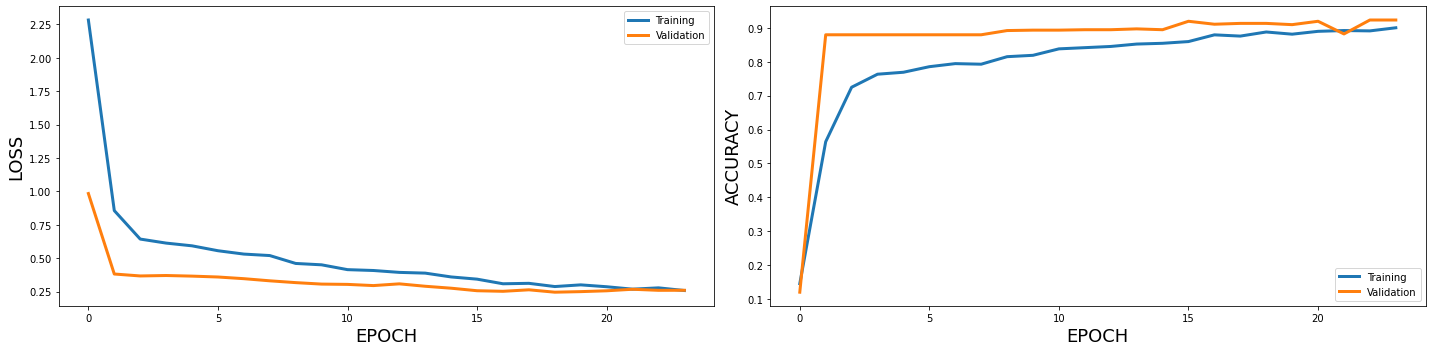

In [199]:
plot_model.plot_history(history)

In [211]:
# model.save_weights('./word2vec/train1')

In [225]:
model = make_model(metrics=METRICS,
                   input_dim=input_dim,
                   embedding_dim=embedding_dim,
                   weights=embedding_matrix,
                   input_length=max_seq_len,
                   output_bias=BIAS
                  )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          3682800   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 200)          160800    
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                13888     
_________________________________________________________________
dense16 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
output4 (Dense)              (None, 2)                 34        
Total params: 3,857,794
Trainable params: 174,994
Non-trainable params: 3,682,800
________________________________________

In [226]:
model.layers[0].embeddings_initializer = keras.initializers.zeros()
model.layers[3].activation = tf.keras.activations.swish

In [227]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    validation_split=0.1,
                    validation_batch_size=1,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=STEPS_x_EPOCH,
                    use_multiprocessing = True,
                    callbacks=[eStop_Val_Loss, eStop_Val_accuracy],
                    workers=6
                    )

Epoch 1/32
20/20 [==============================] - 22s 899ms/step - loss: 2.5789 - accuracy: 0.1415 - val_loss: 0.7471 - val_accuracy: 0.6580
Epoch 2/32
20/20 [==============================] - 17s 849ms/step - loss: 0.8351 - accuracy: 0.5657 - val_loss: 0.3451 - val_accuracy: 0.8794
Epoch 3/32
20/20 [==============================] - 17s 849ms/step - loss: 0.5721 - accuracy: 0.7748 - val_loss: 0.3359 - val_accuracy: 0.8930
Epoch 4/32
20/20 [==============================] - 17s 856ms/step - loss: 0.4916 - accuracy: 0.8071 - val_loss: 0.3187 - val_accuracy: 0.8955
Epoch 5/32
20/20 [==============================] - 17s 863ms/step - loss: 0.4629 - accuracy: 0.8184 - val_loss: 0.3133 - val_accuracy: 0.8980
Epoch 6/32
20/20 [==============================] - 17s 870ms/step - loss: 0.4697 - accuracy: 0.8208 - val_loss: 0.3113 - val_accuracy: 0.8955
Epoch 7/32
20/20 [==============================] - 17s 871ms/step - loss: 0.4490 - accuracy: 0.8281 - val_loss: 0.3028 - val_accuracy: 0.8955

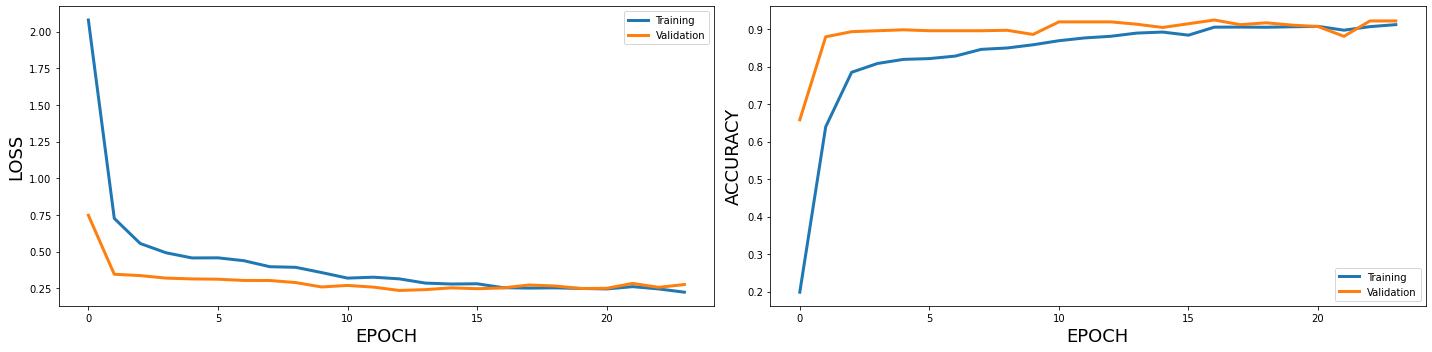

In [228]:
plot_model.plot_history(history)

In [229]:
model.save_weights('./word2vec/train2')

In [244]:
model = make_model(metrics=METRICS,
                   input_dim=input_dim,
                   embedding_dim=embedding_dim,
                   weights=embedding_matrix,
                   input_length=max_seq_len,
                   output_bias=BIAS
                  )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          3682800   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 200)          160800    
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                13888     
_________________________________________________________________
dense16 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
output4 (Dense)              (None, 2)                 34        
Total params: 3,857,794
Trainable params: 174,994
Non-trainable params: 3,682,800
________________________________________

In [245]:
model.layers[0].embeddings_initializer = keras.initializers.zeros()
model.layers[3].activation = tf.keras.activations.relu

In [246]:
EPOCHS = 64

In [247]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    validation_split=0.1,
                    validation_batch_size=1,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
#                     steps_per_epoch=STEPS_x_EPOCH,
                    use_multiprocessing = True,
                    callbacks=eStop_Reduce_lr,
                    workers=6
                    )

Epoch 1/64
19/19 [==============================] - 22s 931ms/step - loss: 2.9623 - accuracy: 0.1180 - val_loss: 1.5058 - val_accuracy: 0.1206
Epoch 2/64
19/19 [==============================] - 16s 887ms/step - loss: 1.4210 - accuracy: 0.3540 - val_loss: 0.5506 - val_accuracy: 0.7861
Epoch 3/64
19/19 [==============================] - 16s 874ms/step - loss: 0.9085 - accuracy: 0.6133 - val_loss: 0.4167 - val_accuracy: 0.7848
Epoch 4/64
19/19 [==============================] - 17s 888ms/step - loss: 0.7452 - accuracy: 0.6981 - val_loss: 0.3691 - val_accuracy: 0.8010
Epoch 5/64
19/19 [==============================] - 17s 901ms/step - loss: 0.6728 - accuracy: 0.7384 - val_loss: 0.3739 - val_accuracy: 0.8968
Epoch 6/64
19/19 [==============================] - 17s 914ms/step - loss: 0.6230 - accuracy: 0.7760 - val_loss: 0.3641 - val_accuracy: 0.8955
Epoch 7/64
19/19 [==============================] - 17s 904ms/step - loss: 0.5938 - accuracy: 0.7883 - val_loss: 0.3392 - val_accuracy: 0.8968

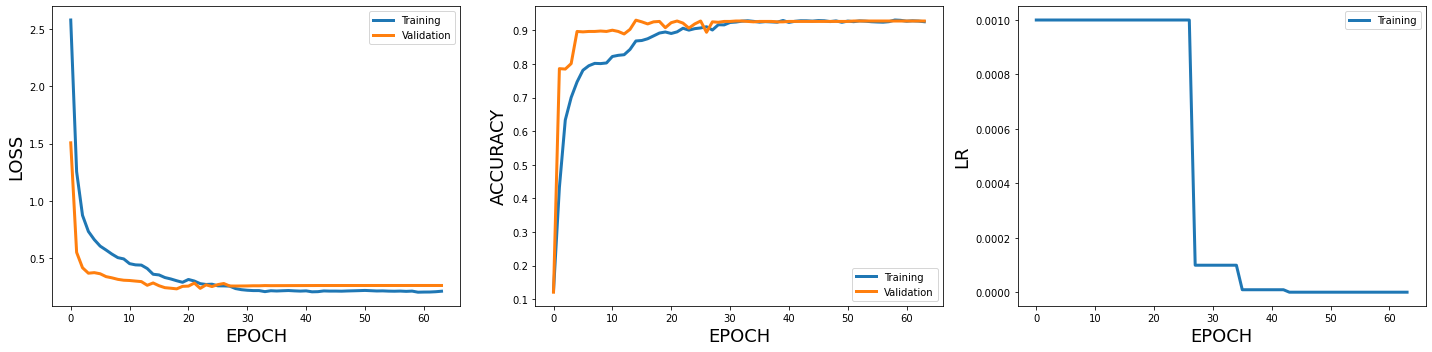

In [570]:
plot_model.plot_history(history)

In [249]:
model.save_weights('./word2vec/word2vec')

In [264]:
score = model.evaluate(X_test, y_test, batch_size=1, steps=X_test.shape[0], workers=8, verbose=0)

In [269]:
y_pred = model.predict(X_test, batch_size=1,verbose=0)

In [572]:
print('Accuracy :', score[1])

Accuracy : 0.928067684173584


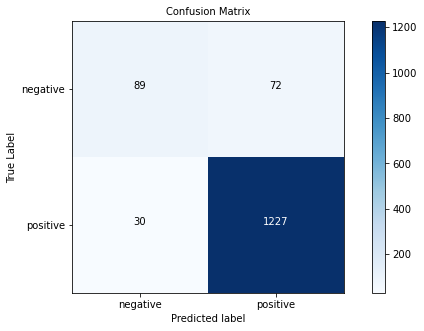

In [571]:
plot_model.confusion_matrix(y_true=y_test, y_pred=y_pred, target_name=ohe.categories_[0], file_name='./img/cm.jpg')

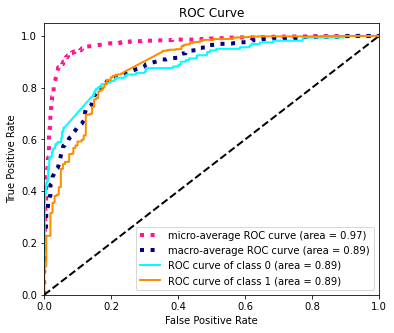

In [573]:
plot_model.plot_roc_curve(y_true=y_test, y_pred=y_pred, file_name='./img/roc.jpg')